## Exploratory data analysis

In [77]:
import pandas as pd
import os
import sys


parent_dir = os.path.join('/home/leandre/Projects/BioMoQA_Playground/')
# Add it to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from src.models.biomoqa import TrainPipeline

2025-06-10 14:17:09,535 - INFO - Random seeds set to 42
2025-06-10 14:17:09,620 - INFO - Optional negatives loaded from CSV with 5000 entries.
2025-06-10 14:17:09,621 - INFO - Loading original negatives...
2025-06-10 14:17:09,628 - INFO - Negatives column names: ['Article ID', 'Title', 'Author', 'Publication year', 'Title secondary', 'URL', 'DOI', 'Abstract', 'Criteria for exclusion A', ' Criteria for exclusion B', ' Criteria for exclusion C', 'labels', 'Keywords']
2025-06-10 14:17:09,628 - INFO - Loading original positives...
2025-06-10 14:17:09,644 - INFO - Positives column names: ['Article ID', 'Title', 'Author', 'Secondary authors', 'Keywords', 'title of unpublished reference', 'primary date', 'publication year', 'notes', 'reprint status', 'start page number', 'ending page number', 'periodical full name', 'periodical standard abbreviation', 'periodical in which article was published', 'periodical name - user abbreviation 1', 'periodical name - user abbreviation 2', 'volume number',

0     Invasive
1      mammals
2        exert
3    pervasive
4      effects
dtype: object


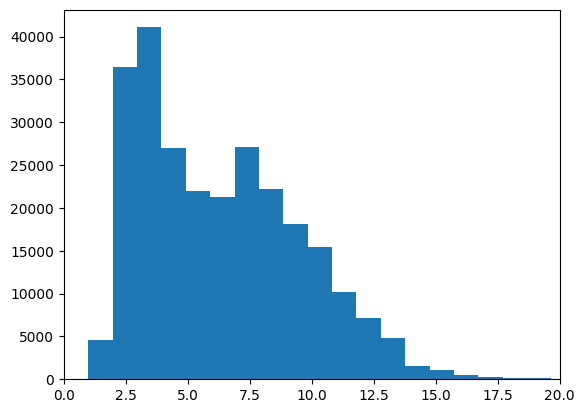

In [78]:
import matplotlib.pyplot as plt

pipeline=TrainPipeline(None,ensemble=True,hpo_metric="eval_f1",with_title=False,with_keywords=False,n_folds=3,n_trials=20, num_runs=2,nb_optional_negs=500)

vocab=[pd.Series(pipeline.dataset.to_pandas()["abstract"][i].split(" ")) for i in range(len(pipeline.dataset))]
vocab=pd.concat(vocab)
print(vocab.head())

plt.hist(vocab.str.len(),bins=vocab.str.len().unique().max())
plt.xlim([0, 20])
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leandre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


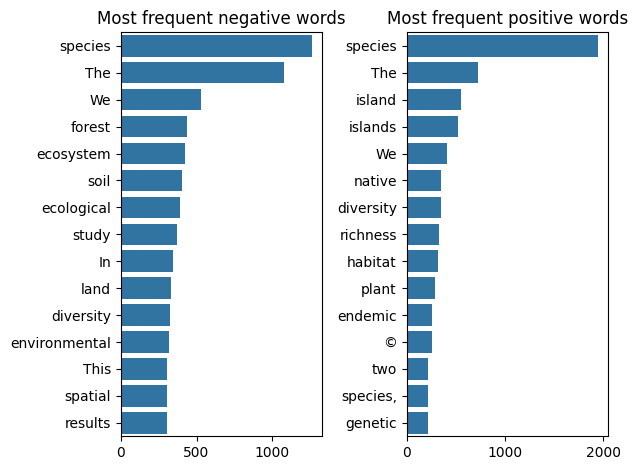

In [83]:

import nltk
from nltk.corpus import stopwords
import seaborn as sns
import numpy as np
import spacy
from collections import Counter

nltk.download('stopwords')
stop=set(stopwords.words('english'))
abstracts_df=pipeline.dataset.to_pandas()

xs=[]
ys=[]
for label in 0,1:
    corpus=[]
    absracts= abstracts_df[abstracts_df['labels']==label]['abstract'].str.split()
    absracts=absracts.values.tolist()
    corpus=[word for i in absracts for word in i]

    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    counter=Counter(corpus)
    most=counter.most_common()

    x, y= [], []
    for word,count in most:
        if (word not in stop):
            x.append(word)
            y.append(count)
    xs.append(x)
    ys.append(y)

fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

for i in range(len(axes)):
    ax=axes[i]
    sns.barplot(x=ys[i][:15],y=xs[i][:15],ax=ax)
    ax.set_title("Most frequent positive words" if i==1 else "Most frequent negative words")

plt.tight_layout()
plt.show()

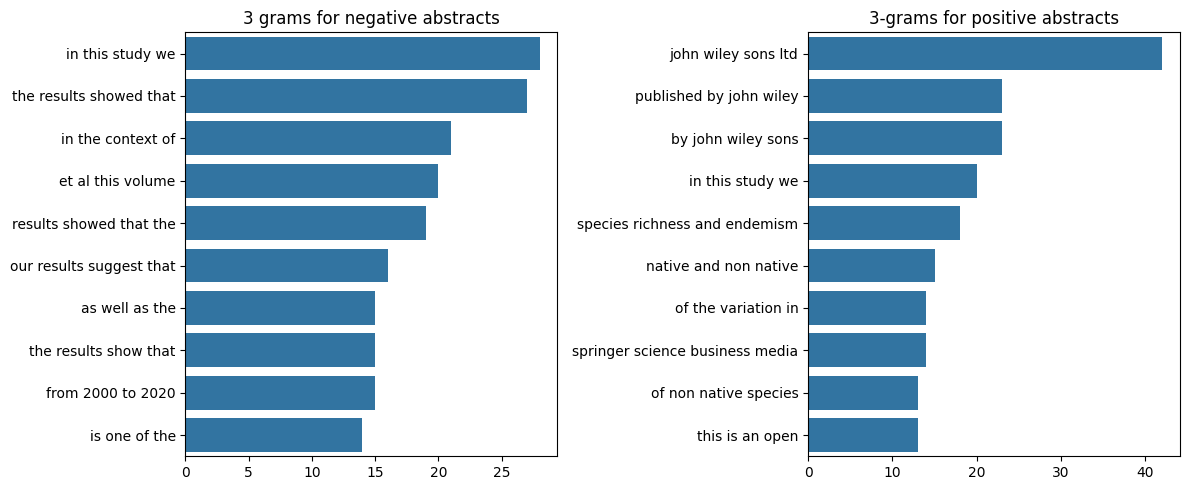

In [80]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for i in range(2):
    ax=axes[i]
    top_tri_grams=get_top_ngram(abstracts_df[abstracts_df['labels']==i]['abstract'],n=4)
    x,y=map(list,zip(*top_tri_grams))
    sns.barplot(x=y,y=x,ax=ax)
    ax.set_title("3-grams for positive abstracts" if i==1 else "3 grams for negative abstracts")
plt.tight_layout()
plt.show()

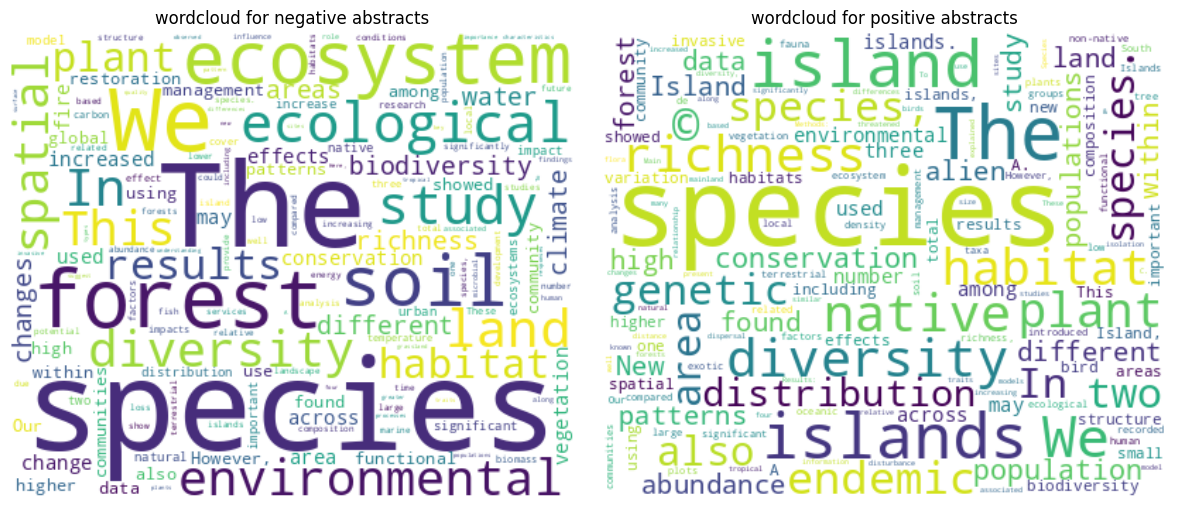

In [99]:
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for i in range(2):
  ax=axes[i]
  pos_word_dict = dict(zip(xs[i], ys[i]))
  wc = WordCloud(width=400, height=330, max_words=150,background_color="white",stopwords=stopwords).generate_from_frequencies(pos_word_dict)
  ax.imshow(wc, interpolation='bilinear')
  ax.set_title("wordcloud for positive abstracts" if i==1 else "wordcloud for negative abstracts")
  ax.axis(False)
plt.tight_layout()
plt.show()